# Imports

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json

from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV1, Options

In [ ]:
token = '' # Put in your IBM token
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite= True)

# Functions for writing CI-Regime Circuits

In [2]:
def twirled_cz(qc, qubit1, qubit2):
    """
    twirl is an integer in {0, 1, ... 15}, representing one of possible 16 Pauli twirls of {I, X, Y, Z}^{otimes 2} in 4-ary.
    repeats is some (odd) number for which the CZ is repeated.
    """
    for _ in range(1):
        twirl = np.random.randint(16)
        match twirl:
            case 0: # II
                qc.cz(qubit1, qubit2)

            case 1:
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.x(qubit2)
            
            case 2:
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit2)

            case 3:
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.y(qubit2)

            case 4:
                qc.x(qubit1)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.z(qubit2)

            case 5:
                qc.x(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.y(qubit2)

            case 6:
                qc.x(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)

            case 7:
                qc.x(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.x(qubit2)

            case 8:
                qc.z(qubit1)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)

            case 9:
                qc.z(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit2)

            case 10:
                qc.z(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.z(qubit2)

            case 11:
                qc.z(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit2)

            case 12:
                qc.y(qubit1)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.z(qubit2)

            case 13:
                qc.y(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.y(qubit2)

            case 14:
                qc.y(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)

            case 15:
                qc.y(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.x(qubit2)

def twirled_cx(qc, qubit1, qubit2):
    """
    twirl is an integer in {0, 1, ... 15}, representing one of possible 16 Pauli twirls of {I, X, Y, Z}^{otimes 2} in 4-ary.
    1 is some (odd) number for which the CX is repeated.
    qubit 1 is the control
    """
    for _ in range(1):
        twirl = np.random.randint(16)
        match twirl:
            case 0:
                qc.cx(qubit1, qubit2)

            case 1:
                qc.x(qubit2)
                qc.cx(qubit1, qubit2)
                qc.x(qubit2)
            
            case 2:
                qc.z(qubit2)
                qc.cx(qubit1, qubit2)
                qc.z(qubit1)
                qc.z(qubit2)

            case 3:
                qc.y(qubit2)
                qc.cx(qubit1, qubit2)
                qc.z(qubit1)
                qc.y(qubit2)

            case 4:
                qc.x(qubit1)
                qc.cx(qubit1, qubit2)
                qc.x(qubit1)
                qc.x(qubit2)

            case 5:
                qc.x(qubit1)
                qc.x(qubit2)
                qc.cx(qubit1, qubit2)
                qc.x(qubit1)

            case 6:
                qc.x(qubit1)
                qc.z(qubit2)
                qc.cx(qubit1, qubit2)
                qc.y(qubit1)
                qc.y(qubit2)

            case 7:
                qc.x(qubit1)
                qc.y(qubit2)
                qc.cx(qubit1, qubit2)
                qc.y(qubit1)
                qc.z(qubit2)

            case 8:
                qc.z(qubit1)
                qc.cx(qubit1, qubit2)
                qc.z(qubit1)

            case 9:
                qc.z(qubit1)
                qc.x(qubit2)
                qc.cx(qubit1, qubit2)
                qc.z(qubit1)
                qc.x(qubit2)

            case 10:
                qc.z(qubit1)
                qc.z(qubit2)
                qc.cx(qubit1, qubit2)
                qc.z(qubit2)

            case 11:
                qc.z(qubit1)
                qc.y(qubit2)
                qc.cx(qubit1, qubit2)
                qc.y(qubit2)

            case 12:
                qc.y(qubit1)
                qc.cx(qubit1, qubit2)
                qc.y(qubit1)
                qc.x(qubit2)

            case 13:
                qc.y(qubit1)
                qc.x(qubit2)
                qc.cx(qubit1, qubit2)
                qc.y(qubit1)
    

            case 14:
                qc.y(qubit1)
                qc.z(qubit2)
                qc.cx(qubit1, qubit2)
                qc.x(qubit1)
                qc.y(qubit2)

            case 15:
                qc.y(qubit1)
                qc.y(qubit2)
                qc.cx(qubit1, qubit2)
                qc.x(qubit1)
                qc.z(qubit2)

In [3]:
def twirled_swap(qc, qubit1, qubit2):
    twirled_cx(qc, qubit1, qubit2)
    twirled_cx(qc, qubit2, qubit1)
    twirled_cx(qc, qubit1, qubit2)

def twirled_rxx(qc, phi, qubit1, qubit2):
    qc.h([qubit1, qubit2])
    twirled_cx(qc, qubit1, qubit2)
    qc.rz(phi, qubit2)
    twirled_cx(qc, qubit1, qubit2)
    qc.h([qubit1, qubit2])

def give_base_circuit(qc, phi):
    qc.h([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    twirled_cz(qc, 0, 1)
    twirled_cz(qc, 2, 3)
    twirled_cz(qc, 4, 5)
    twirled_cz(qc, 6, 7)
    twirled_cz(qc, 8, 9)
    twirled_cz(qc, 1, 2)
    twirled_cz(qc, 3, 4)
    twirled_cz(qc, 5, 6)
    twirled_cz(qc, 7, 8)
    twirled_cz(qc, 9, 10)

    twirled_swap(qc, 2, 3)
    twirled_swap(qc, 7, 8)
    twirled_rxx(qc, phi, 3, 4)
    twirled_rxx(qc, phi, 6, 7)
    twirled_swap(qc, 5, 6)
    twirled_rxx(qc, phi, 4, 5)

    qc.rx(phi, 3)
    qc.rx(phi, 7)

In [4]:
def generate_tworot_circuit(beta, phi, meas_last_x):
    """
    Generates one circuit corresponding to doing two close rotations
    A cluster state is prepared, then a rotation is conducted on the third/fifth sites. A state tomography measurement
    (either X or Y) is conducted on the last (11th) qubit.

    Inputs: beta - Rotation angle
            phi - R_{ZkZk+2}(phi) rotation applied across 2-local connections
            meas_last_x - Whether the ninth qubit is measured in the Y or X basis
    Outputs: The circuit
    """
    qr = QuantumRegister(11)
    cr = ClassicalRegister(11)
    qc = QuantumCircuit(qr, cr)

    give_base_circuit(qc, phi)

    qc.rz(beta/2, 3)
    qc.rz(beta/2, 4)

    if meas_last_x == 0:
        qc.sdg(10)  

    qc.h(qr)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(3, 2)
    qc.measure(2, 3)
    qc.measure(4, 4)
    qc.measure(6, 5)
    qc.measure(5, 6)
    qc.measure(8, 7)
    qc.measure(7, 8)
    qc.measure(9, 9)
    qc.measure(10, 10)
    
    return qc

def generate_tworot_circuit_spaced(beta, phi, meas_last_x):
    """
    Generates one circuit corresponding to doing two spaced rotations
    A cluster state is prepared, then a rotation is conducted on the third/ninth sites. A state tomography measurement
    (either X or Y) is conducted on the last (11th) qubit.

    Inputs: beta - Rotation angle
            phi - R_{ZkZk+2}(phi) rotation applied across 2-local connections
            meas_last_x - Whether the ninth qubit is measured in the Y or X basis
    Outputs: The circuit
    """
    qr = QuantumRegister(11)
    cr = ClassicalRegister(11)
    qc = QuantumCircuit(qr, cr)

    give_base_circuit(qc, phi)

    qc.rz(beta/2, 3)
    qc.rz(beta/2, 7)

    if meas_last_x == 0:
        qc.sdg(10)  

    qc.h(qr)
    
    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(3, 2)
    qc.measure(2, 3)
    qc.measure(4, 4)
    qc.measure(6, 5)
    qc.measure(5, 6)
    qc.measure(8, 7)
    qc.measure(7, 8)
    qc.measure(9, 9)
    qc.measure(10, 10)
    
    return qc

def generate_fourrot_circuit(beta, phi, meas_last_x):
    qr = QuantumRegister(11)
    cr = ClassicalRegister(11)
    qc = QuantumCircuit(qr, cr)

    give_base_circuit(qc, phi)

    qc.rz(beta/4, 3)
    qc.rz(beta/4, 4)
    qc.rz(beta/4, 5)
    qc.rz(beta/4, 7)

    if meas_last_x == 0:
        qc.sdg(10)  

    qc.h(qr)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(3, 2)
    qc.measure(2, 3)
    qc.measure(4, 4)
    qc.measure(6, 5)
    qc.measure(5, 6)
    qc.measure(8, 7)
    qc.measure(7, 8)
    qc.measure(9, 9)
    qc.measure(10, 10)
    
    return qc

In [5]:
def generate_counterintuitive_circuits(beta_ar, phi_ar, repeats=1):
    """
    Generates n circuits (one for each rotation angle)
    Inputs: beta_ar - array of rotation angles
            ab_ar - array of variational ansatz states
    Outputs: List of 2 * len(beta_ar) circuits
    """ 
    qc_list = []
    for phi in phi_ar:
        for num_rots in [2, 22, 4]:
            for beta in beta_ar:
                for meas_last_x in range(2):
                        for _ in range(repeats):
                            if num_rots == 2:
                                qc_list.append(generate_tworot_circuit(beta, phi, meas_last_x))
                            elif num_rots == 22:
                                qc_list.append(generate_tworot_circuit_spaced(beta, phi, meas_last_x))
                            else:
                                qc_list.append(generate_fourrot_circuit(beta, phi, meas_last_x))
    return qc_list

# Running the CI-regime circuits

In [3]:
best_qubits = [8, 9, 10, 11, 12, 17, 30, 31, 32, 36, 51]
shots_num = 10000
beta_ar = np.linspace(0, np.pi/2, 8)
phi_ar = [np.pi/4]
num_repeats_CI = 6

In [4]:
service = QiskitRuntimeService()
backend = service.backend("ibm_quebec")

In [ ]:
with Session(service=service, backend=backend, max_time="1h") as session:
    options = Options()
    options.resilience_level = 1
    options.optimization_level = 0
    sampler = SamplerV1(session=session, options=options)
    print(session.details())
    print(session.status())

    qc_list_CI = transpile(generate_counterintuitive_circuits(beta_ar, phi_ar, num_repeats_CI), backend=backend, intial_layout=best_qubits)
    job_exp_CI = sampler.run(qc_list_CI, shots=shots_num)
    print(session.status())

# Post-processing Data

In [24]:
job_names = ["csfkxm69as1g0081dacg", "csfkz4c9as1g0081dadg", "csfm0r30a9s0008e1x9g", "csfm29s6nagg008qdax0", "csfm3w76nagg008qdazg", "csfm5bx6nagg008qdb30", "csfm6yk6nagg008qdb8g", "csfm8jtpvsk0008rcnng", "csfma5r0a9s0008e1y40", "csfmbq6pvsk0008rcnr0", "csfmd7wbm6a0008970ng", "csfmept6nagg008qdc1g", "csfmg5rjm3kg008qzf4g", "csfmhpybm6a0008970yg", "csfmk7c6nagg008qdc70", "csfmmr39as1g0081dc6g", "csfmp91jm3kg008qzfc0", "csfmqsqpvsk0008rcpbg", "csfmsan6nagg008qdcgg", "csfmtv30a9s0008e1yy0", "csjd7j61k2e0008nr7t0", "csjd8vkea560008f2vb0", "csjda5g3fxq0008c2mt0", "csjdbexp1vzg0089ygx0", "csjdcrv3fxq0008c2n60", "csjde28vnxy0008czaw0", "csjdfbnvwqp0008anwh0", "csjdgn2vnxy0008czb0g", "csjdhyq1k2e0008nr89g", "csjdk85vnxy0008czb40", "csjdmj2p1vzg0089yhsg", "csjdntqvnxy0008czb80", "csjdq4cp1vzg0089yj2g", "csjdrd9p1vzg0089yjag", "csjdsny3fxq0008c2pc0", "csjdty3vnxy0008czbs0", "csjdw4gea560008f2wqg", "csjdxb53fxq0008c2q5g", "csjdykjp1vzg0089ykg0", "csjdzw7vnxy0008czcdg", "csjmh3c1k2e0008ns6s0", "csjmjr33fxq0008c3r6g", "csjmm993fxq0008c3sj0", "csjmnv73fxq0008c3tq0", "csjmqan3fxq0008c3w40", "csjmrsv3fxq0008c3xa0", "csjmt913fxq0008c3yv0", "csjmvpp3fxq0008c4090", "csjmx443fxq0008c41h0", "csjmyh23fxq0008c42tg", "csjmzzfvnxy0008d0re0", "csjn1e5vwqp0008aq0sg", "csjn2wbvwqp0008aq1zg", "csjn4asp1vzg0089zv6g", "csjn5sf1k2e0008nsstg", "csjn77wea560008f4650", "csjn8ptp1vzg0089zxfg", "csjna58p1vzg0089zxk0", "csjnbkp3fxq0008c4agg", "csjnd2cea560008f46tg", "csjxnt7p1vzg008a0krg", "csjxqp6vnxy0008d22h0", "csjxt503fxq0008c5dqg", "csjxw58vwqp0008aqtb0", "csjxyx33fxq0008c5e30", "csjy1nyp1vzg008a0m8g", "csjy3hep1vzg008a0mfg", "csjy574vwqp0008aqtwg", "csjy6wb1k2e0008ntx7g", "csjy8g2vwqp0008aqvn0", "csjya68p1vzg008a0nc0", "csjybxqvnxy0008d24eg", "csjydme1k2e0008ntxt0", "csjyfadvnxy0008d250g", "csjygzv1k2e0008nty40", "csjyjpap1vzg008a0phg", "csjymcs1k2e0008ntykg", "csjyp381k2e0008ntyr0", "csjyqqe1k2e0008ntz00", "csjysdnp1vzg008a0qe0"]

In [15]:
def decimal_to_bin(base10, digits):
    zero_dig = str(base10 // 2**0 % 2)
    one_dig = str(base10 // 2**1 % 2)
    two_dig = str(base10 // 2**2 % 2)
    three_dig = str(base10 // 2**3 % 2)
    four_dig = str(base10 // 2**4 % 2)
    five_dig = str(base10 // 2**5 % 2)
    six_dig = str(base10 // 2**6 % 2)
    seven_dig = str(base10 // 2**7 % 2)
    eight_dig = str(base10 // 2**8 % 2)
    nine_dig = str(base10 // 2 **9 % 2)
    ten_dig = str(base10// 2**10 % 2)
    return ten_dig + nine_dig + eight_dig + seven_dig + six_dig + five_dig + four_dig + three_dig + two_dig + one_dig + zero_dig

def convert_to_counts(quasi_dist_dict, shots, digits):
    count_dict = {}
    for key, val in quasi_dist_dict.items():
        count_dict[decimal_to_bin(int(key), digits)] = val * shots
    return count_dict

In [16]:
def convert_bin(s):
    if s == 0:
        return 1
    else:
        return -1

def tworot_expectation(counts, meas_last_x):
    states = counts.keys()
    exp_val_correct = 0
    total_counts_correct = 0
    for state in states:
        count = counts.get(state)
        s1 = convert_bin(int(state[10]))
        # s2 = convert_bin(int(state[9]))
        s3 = convert_bin(int(state[8]))
        s4 = convert_bin(int(state[7]))
        s5 = convert_bin(int(state[6]))
        s6 = convert_bin(int(state[5]))
        s7 = convert_bin(int(state[4]))
        s8 = convert_bin(int(state[3]))
        s9 = convert_bin(int(state[2]))
        s10 = convert_bin(int(state[1]))
        s11 = convert_bin(int(state[0]))

        if meas_last_x == 1:
                s6 = 1
                s8 = 1
                s10 = 1
        outcome = s1 * s3 * s5 * s7 * s9 * s11 * s6 * s8 * s10
        if s4 == 1:
            exp_val_correct += outcome * count
            total_counts_correct += count
        
    return exp_val_correct/total_counts_correct

def tworot_expectation_spaced(counts, meas_last_x):
    states = counts.keys()
    exp_val_correct = 0
    total_counts_correct = 0
    for state in states:
        count = counts.get(state)
        s1 = convert_bin(int(state[10]))
        # s2 = convert_bin(int(state[9]))
        s3 = convert_bin(int(state[8]))
        s4 = convert_bin(int(state[7]))
        s5 = convert_bin(int(state[6]))
        s6 = convert_bin(int(state[5]))
        s7 = convert_bin(int(state[4]))
        s8 = convert_bin(int(state[3]))
        s9 = convert_bin(int(state[2]))
        s10 = convert_bin(int(state[1]))
        s11 = convert_bin(int(state[0]))

        if meas_last_x == 1:
                s10 = 1
            
        outcome = s1 * s3 * s5 * s7 * s9 * s11 * s10
        if s4 * s6 * s8 == 1:
            exp_val_correct += outcome * count
            total_counts_correct += count
        
    return exp_val_correct/total_counts_correct

def fourrot_expectation(counts, meas_last_x):
    states = counts.keys()
    exp_val_correct = 0
    total_counts_correct = 0

    for state in states:
        count = counts.get(state)
        s1 = convert_bin(int(state[10]))
        # s2 = convert_bin(int(state[9]))
        s3 = convert_bin(int(state[8]))
        s4 = convert_bin(int(state[7]))
        s5 = convert_bin(int(state[6]))
        s6 = convert_bin(int(state[5]))
        s7 = convert_bin(int(state[4]))
        s8 = convert_bin(int(state[3]))
        s9 = convert_bin(int(state[2]))
        s10 = convert_bin(int(state[1]))
        s11 = convert_bin(int(state[0]))

        if meas_last_x == 1:
            s10 = 1
        
        outcome = s1 * s3 * s5 * s7 * s9 * s11 * s10
        
        if s4 == 1 and s6 == 1 and s8 == 1:
            exp_val_correct += outcome * count
            total_counts_correct += count
        # Other cases have different purities and therefore must be discarded.

    return exp_val_correct/total_counts_correct


In [17]:
def post_process_results(counts_list, beta_ar, phi_ar):
    """
    Inputs: counts_list - measurement outcomes from two circuits
    beta - rotation angle
    a, b - Parameters for T.

    Outputs:Yavg, Xavg
    """
    i = 0
    results = []
    for _ in phi_ar:
        for num_rots in [2, 22, 4]:
            for _ in beta_ar:
                if num_rots == 2:
                    Yc = tworot_expectation(counts_list[i], 0)
                    Xc = tworot_expectation(counts_list[i+1], 1)
                elif num_rots == 22:
                    Yc = tworot_expectation_spaced(counts_list[i], 0)
                    Xc = tworot_expectation_spaced(counts_list[i+1], 1)
                else:
                    Yc = fourrot_expectation(counts_list[i], 0)
                    Xc = fourrot_expectation(counts_list[i+1], 1)
                purity = (1 - Yc**2 - Xc**2)
                results.append(purity)
                i += 2
    return results

In [25]:
# Extract quasi_probability distribution dictionaries from files

quasi_dist_list_CI = []
for job_name in job_names:
    f = open("raw_data/CI_" + job_name + ".json")
    quasi_dist_f = json.load(f)
    quasi_dist_list_CI.append(quasi_dist_f)
    f.close()

In [26]:
# Convert quasi-probability distributions to counts

counts_list_across_repeats_CI = []
k = 0
for run in quasi_dist_list_CI:
    for j in range(num_repeats_CI):
        counts_list = []
        for i in range(len(run)//num_repeats_CI):
            counts_list.append(convert_to_counts(run[num_repeats_CI * i + j], shots_num, 11))
        counts_list_across_repeats_CI.append(counts_list)

In [27]:
# Calculate expectation values

purity_ars = []
for counts_list in counts_list_across_repeats_CI:
    purity_ar = post_process_results(counts_list, beta_ar, phi_ar)
    purity_ars.append(purity_ar)
purity_ars = np.array(purity_ars)

In [28]:
# Calculating means and standard errors of means

purity_ar_mean = np.mean(purity_ars, axis=0)
purity_ar_std = np.std(purity_ars, axis=0)/np.sqrt(len(purity_ars))

num_betas = len(beta_ar)
two_rot_close_purity_ar = purity_ar_mean[0*num_betas:1*num_betas]
two_rot_close_purity_err_ar = purity_ar_std[0*num_betas:1*num_betas]
two_rot_far_purity_ar = purity_ar_mean[1*num_betas:2*num_betas]
two_rot_far_purity_err_ar = purity_ar_std[1*num_betas:2*num_betas]
four_rot_purity_ar = purity_ar_mean[2*num_betas:3*num_betas]
four_rot_purity_err_ar = purity_ar_std[2*num_betas:3*num_betas]

In [ ]:
np.savez("processed_data/CI_purities.npz", beta_ar=beta_ar, two_rot_close_purity_ar=two_rot_close_purity_ar, two_rot_close_purity_err_ar=two_rot_close_purity_err_ar, two_rot_far_purity_ar=two_rot_far_purity_ar, two_rot_far_purity_err_ar=two_rot_far_purity_err_ar, four_rot_purity_ar=four_rot_purity_ar, four_rot_purity_err_ar=four_rot_purity_err_ar)

## Noisy Simulation

In [33]:
shots_num_sim = 4000000
beta_ar_sim = np.linspace(0, np.pi/2, 50)
qc_list_sim = generate_counterintuitive_circuits(beta_ar_sim, phi_ar)

In [65]:
noise_model = NoiseModel()
p_gate = 0.046

# Add depolarizing error to all 2-qubit gates
error_gate2 = depolarizing_error(p_gate, 2)
noise_model.add_all_qubit_quantum_error(error_gate2, ["cz"])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Print noise model info
print(noise_model)

sim_noise = AerSimulator(noise_model=noise_model)

NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cz', 'cx']
  All-qubits errors: ['cz', 'cx']


In [66]:
job_sim = sim_noise.run(qc_list_sim, shots=shots_num_sim)
job_sim_result = job_sim.result()

In [71]:
counts_list_sim = []
for i in range(len(qc_list_sim)):
    counts_list_sim.append(job_sim_result.get_counts(i))

CI_ar_sim = post_process_results(counts_list_sim, beta_ar_sim, phi_ar)
tworot_purities_sim = CI_ar_sim[0*len(beta_ar_sim):1*len(beta_ar_sim)]
tworot_spaced_purities_sim = CI_ar_sim[1*len(beta_ar_sim):2*len(beta_ar_sim)]
fourrot_purities_sim = CI_ar_sim[2*len(beta_ar_sim):3*len(beta_ar_sim)]

In [35]:
data = np.load("processed_data/CI_purities_sim_optimal_p046_4mshots.npz")
beta_ar_sim = data["beta_ar"]
tworot_purities_sim = data["tworot_purities_sim"]
tworot_spaced_purities_sim = data["tworot_spaced_purities_sim"]
fourrot_purities_sim = data["fourrot_purities_sim"]

In [ ]:
data = np.load("processed_data/CI_purities.npz")
beta_ar = data["beta_ar"]
two_rot_close_purity_ar = data["two_rot_close_purity_ar"]
two_rot_close_purity_err_ar = data["two_rot_close_purity_err_ar"]
two_rot_far_purity_ar = data["two_rot_far_purity_ar"]
two_rot_far_purity_err_ar = data["two_rot_far_purity_err_ar"]
four_rot_purity_ar = data["four_rot_purity_ar"]
four_rot_purity_err_ar = data["four_rot_purity_err_ar"]

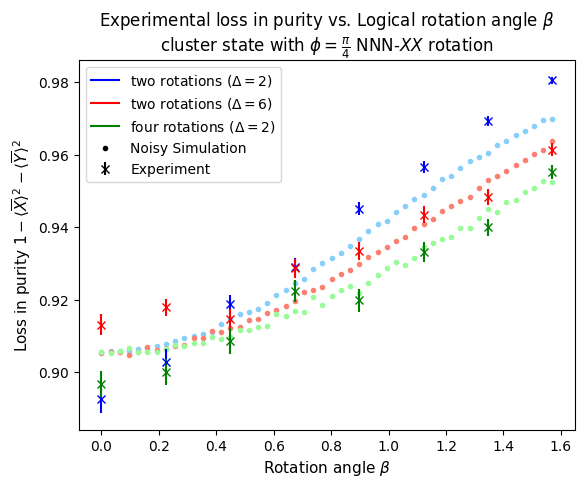

In [48]:
plt.plot(beta_ar_sim, tworot_purities_sim, ".", color = "lightskyblue")
plt.plot(beta_ar_sim, tworot_spaced_purities_sim, ".", color = "salmon")
plt.plot(beta_ar_sim, fourrot_purities_sim, ".", color = "palegreen")

plt.errorbar(beta_ar, two_rot_close_purity_ar, yerr=two_rot_close_purity_err_ar, fmt="x", color="blue")
plt.errorbar(beta_ar, two_rot_far_purity_ar, yerr=two_rot_far_purity_err_ar, fmt="x", color="red")
plt.errorbar(beta_ar, four_rot_purity_ar, yerr=four_rot_purity_err_ar, fmt="x", color="green")

plt.plot([], [], "b-", label=r"two rotations ($\Delta=2$)")
plt.plot([], [], "r-", label=r"two rotations ($\Delta=6$)")
plt.plot([], [], "g-", label=r"four rotations ($\Delta = 2$)")
# plt.plot([], [], "k-", label="Theory")
plt.plot([], [], "k.", label="Noisy Simulation")
plt.errorbar([], [], [], fmt="x", color="black", label="Experiment")

plt.title(r"Experimental loss in purity vs. Logical rotation angle $\beta$" + "\n" + r"cluster state with $\phi = \frac{\pi}{4}$ NNN-$XX$ rotation")
plt.xlabel(r"Rotation angle $\beta$", size=11)
plt.ylabel(r"Loss in purity $1 - \langle \overline{X} \rangle^2 - \langle \overline{Y} \rangle^2$", size=11)
plt.legend(loc="best")
plt.savefig("figures/CI_purity.pdf")
plt.show()